In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import datetime
from sklearn import linear_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 16, 8
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [28]:
data = pd.read_excel(r"/Users/peterfeng/Downloads/积累/Previous Courses Materials/UChicago Past Courses/UChicago 2021 Fall/Portfolio Theory/hw data/proshares_analysis_data.xlsx", sheet_name = 'hedge_fund_series')
data.set_index('date',inplace=True)
data.head()

factor_data = pd.read_excel(r"/Users/peterfeng/Downloads/积累/Previous Courses Materials/UChicago Past Courses/UChicago 2021 Fall/Portfolio Theory/hw data/proshares_analysis_data.xlsx", sheet_name = 'merrill_factors')
factor_data = factor_data.set_index('date')

## Section 2
## 1.

1. For the series in the “hedge fund series” tab, report the following summary statistics:

    (a) mean
    
    (b) volatility
    
    (c) Sharpe ratio
    
    Annualize these statistics

In [69]:
def summary_stats(df):
     
    mean_return = df.mean() * 12   # scaling by 12
    vol = df.std() * np.sqrt(12)  # scaling by sqrt of 12
    sharpe = mean_return / vol   
    
    stats = pd.DataFrame({
        'Avg Return' : mean_return,
        'Avg Volatility' : vol,
        'Sharpe Ratio' : sharpe
    })
    
    return stats

summ = summary_stats(data)

summ


,Avg Return,Avg Volatility,Sharpe Ratio
HFRIFWI Index,0.050784,0.061507,0.825665
MLEIFCTR Index,0.038821,0.053848,0.720933
MLEIFCTX Index,0.037330,0.053682,0.695382
HDG US Equity,0.028100,0.056380,0.498407
QAI US Equity,0.025491,0.045484,0.560434


## 2.  (a), (b), (c)

2. For the series in the “hedge fund series” tab, , calculate the following statistics related to tailrisk.

    (a) Skewness
    
    (b) Excess Kurtosis (in excess of 3)
    
    (c) VaR (.05) - the fifth quantile of historic returns
    
    (d) CVaR (.05) - the mean of the returns at or below the fifth quantile
    
    (e) Maximum drawdown - include the dates of the max/min/recovery within the max drawdown

In [34]:
# def percentile(df_2):
#     return np.percentile(df_2, 5)

# def summary_stats_exp(df):
     
#     mean_return = df.mean() * 12   # scaling by 12
#     vol = df.std() * np.sqrt(12)  # scaling by sqrt of 12
#     sharpe = mean_return / vol   # scaling by 12 ### *np.sqrt(12)
#     skewness = df.skew()
#     ex_kurtosis = df.kurtosis()
#     VaR = df.quantile(0.05)
#     CVaR = df[df < df.quantile(0.05)].mean()  #Expected Shortfall
#     stats = pd.DataFrame({
#         'Avg Return' : mean_return,
#         'Avg Volatility' : vol,
#         'Sharpe Ratio' : sharpe,
#         'Skewness': skewness,
#         'Kurtosis': ex_kurtosis,
#         'VaR': VaR,
#         'CVaR': CVaR
#     })
    
#     return stats

# summ_exp = summary_stats_exp(data)

# summ_exp

## improved method
def tail_risk_report(data, q):
    df = data.copy()
    df.index = data.index.date
    report = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness'] = df.skew()
    report.loc['Excess Kurtosis'] = df.kurtosis()
    report.loc['VaR'] = df.quantile(q)
    report.loc['Expected Shortfall'] = df[df < df.quantile(q)].mean() #CVaR
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()
    report.loc['MDD Start'] = None
    report.loc['MDD End'] = drawdown.idxmin()
    report.loc['Recovery Date'] = None
    
    for col in df.columns:
        report.loc['MDD Start', col] = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df = (drawdown.loc[report.loc['MDD End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col] = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days

        except:
            report.loc['Recovery Date', col] = None
            report.loc['Recovery period (days)'] = None

    return round(report,4)
tail_risk_report(data, 0.05)

2011-08-31    0.967851
2011-09-30    0.967851
2011-10-31    0.967851
2011-11-30    0.967851
2011-12-31    0.967851
                ...   
2019-11-30    1.310816
2019-12-31    1.335573
2020-01-31    1.335573
2020-02-29    1.335573
2020-03-31    1.335573
Name: HFRIFWI Index, Length: 104, dtype: float64
2011-08-31    0.974412
2011-09-30    0.974412
2011-10-31    0.983928
2011-11-30    0.983928
2011-12-31    0.983928
                ...   
2019-11-30    1.294499
2019-12-31    1.312616
2020-01-31    1.312616
2020-02-29    1.312616
2020-03-31    1.312616
Name: MLEIFCTR Index, Length: 104, dtype: float64
2011-08-31    0.974311
2011-09-30    0.974311
2011-10-31    0.983387
2011-11-30    0.983387
2011-12-31    0.983387
                ...   
2019-11-30    1.274815
2019-12-31    1.292571
2020-01-31    1.292571
2020-02-29    1.292571
2020-03-31    1.292571
Name: MLEIFCTX Index, Length: 104, dtype: float64
2011-08-31    0.972965
2011-09-30    0.972965
2011-10-31    0.988946
2011-11-30    0.988946


,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Skewness,-1.109248,-0.186692,-0.171632,-0.179641,-0.545085
Excess Kurtosis,6.730109,2.429484,2.375597,2.581654,2.669553
VaR,-0.025311,-0.025527,-0.025629,-0.028529,-0.016172
Expected Shortfall,-0.038757,-0.032779,-0.032724,-0.034782,-0.026348
Max Drawdown,-0.115473,-0.0845,-0.083673,-0.088245,-0.075649
MDD Start,2019-12-31,2019-12-31,2019-12-31,2020-01-31,2019-12-31
MDD End,2020-03-31,2020-03-31,2020-03-31,2020-03-31,2020-03-31
Recovery Date,2020-08-31,2020-11-30,2020-11-30,2020-11-30,2020-07-31
Recovery period (days),244,335,335,304,213


## 2. (e)

In [89]:
# def max_drawdown(df):
#     cum_returns = (1 + df).cumprod()
#     rolling_max = cum_returns.cummax()
#     drawdown = (cum_returns - rolling_max) / rolling_max
#     min_date = drawdown.idxmin()
    
#     cum_returns_adj = cum_returns.loc[:min_date]
#     cum_returns_previous = cum_returns.loc[:min_date]
#     cum_returns_post = cum_returns.loc[min_date:]

#     recovery_date = 0
#     for i in cum_returns_post.index:
#         if (cum_returns_post.loc[i] > cum_returns_previous.max() and recovery_date == 0):
#             recovery_date = i

#     return drawdown.min(), drawdown.idxmin(), cum_returns_previous.idxmax(), recovery_date

In [90]:
# def draw(df):
#     return drawdown[str(df)].min()
   

In [91]:
# draw_dates = data.agg(max_drawdown, axis = 0)

In [92]:
# draw_dates.rename(index = {0:'Max. Drawdown', 1:'Date of Max. Drawdown',2:'Date of Previous Peak',3: 'Date of Recovery'}, inplace = True)

# draw_dates

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Max. Drawdown,-0.115473,-0.0844997,-0.0836731,-0.0882451,-0.0756486
Date of Max. Drawdown,2020-03-31 00:00:00,2020-03-31 00:00:00,2020-03-31 00:00:00,2020-03-31 00:00:00,2020-03-31 00:00:00
Date of Previous Peak,2019-12-31 00:00:00,2019-12-31 00:00:00,2019-12-31 00:00:00,2020-01-31 00:00:00,2019-12-31 00:00:00
Date of Recovery,2020-08-31 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-07-31 00:00:00


## Problem 3

In [93]:
data_merr = pd.read_excel('proshares_analysis_data.xlsx', sheet_name = 'merrill_factors')

data_merr.set_index('date', inplace = True)

In [94]:
data_merr.head()

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
date,,,,,,
2011-08-31,-0.054976,0.000009,-0.092549,-0.087549,-0.005889,-0.088913
2011-09-30,-0.069449,0.000017,-0.179064,-0.108083,0.142180,-0.111541
2011-10-31,0.109147,-0.000013,0.162986,0.096275,-0.069502,0.151012
2011-11-30,-0.004064,0.000000,-0.019723,-0.021764,0.054627,-0.003783
2011-12-31,0.010440,0.000009,-0.043017,-0.022139,0.075581,0.005114


In [32]:
# def reg_stats(df_portfolio,df_factors,portfolio):
#     reg_stats = pd.DataFrame()
#     beta_result = pd.Series()
#     unexplained_vol = pd.Series()
#     excess_return = pd.Series()
 
#     factors = df_factors.columns
#     for factor in factors:
#         rhs = sm.add_constant(df_portfolio[portfolio])
#         lhs = df_factors[factor]
#         model = sm.OLS(lhs,rhs,missing='drop').fit()
#         beta = model.params[portfolio]
#         beta_result[factor] = beta
 
#         residual = model.resid
#         unexplained_vol[factor] = residual.std()
#         excess_return[factor] = model.params['const']
 
#     reg_stats['Market Beta'] = beta_result
#     reg_stats['Treynor Ratio'] = df_factors.mean() * 12/reg_stats['Market Beta']
#     reg_stats['Information Ratio'] = excess_return/(unexplained_vol*np.sqrt(12))
#     return reg_stats


def reg_stats(df, annual_fac):
    reg_stats = pd.DataFrame(data = None, index = df.columns, columns = ['beta', 
                                                                         'Treynor Ratio', 
                                                                         'Information Ratio'])
    for col in df.columns:
        # Drop the NAs in y
        y = df[col].dropna()
        # Align the X with y 
        X = sm.add_constant(factor_data['SPY US Equity'].loc[y.index])
        reg = sm.OLS(y, X).fit()
        reg_stats.loc[col, 'beta'] = reg.params[1]
        reg_stats.loc[col, 'Treynor Ratio'] = (df[col].mean() * annual_fac) / reg.params[1]
        reg_stats.loc[col, 'Information Ratio'] = (reg.params[0] / reg.resid.std()) * np.sqrt(annual_fac)

    return reg_stats.astype(float).round(4)

reg_stats(data,12)

/Users/peterfeng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,beta,Treynor Ratio,Information Ratio
HFRIFWI Index,0.3943,0.1288,-0.2420
MLEIFCTR Index,0.3594,0.1080,-0.6153
MLEIFCTX Index,0.3580,0.1043,-0.6713
HDG US Equity,0.3692,0.0761,-1.0106
QAI US Equity,0.2850,0.0894,-0.6873


## Problem 4

4. 
    a. The market beta here indicates the risk of the hedge-fund series related to SPY. The betas for all five hedge-fund series are ranging from 0.28 to nearly 0.4, which means the components in the hedge-fund series are quite different from the components of SPY. 

    b. The Treynor ratio, pretty similar to the Sharpe ratio, is a return/risk measure that shows the profitability of a portfolio regarding its risk. Higher Treynor ratio means the portfolio is a better investment. By comparing the Treynor ratio of HDG and QAI – 0.076 versus 0.089 – we know QAI performs better.
    
    c. HDG and ML do not capture the most notable properties of HFRI. HFRI has the highest market beta, which means its risk is more related to SPY. HFRI also has a higher Treynor ratio which means it is more profitable per unit of risk. Also, it has a higher information ratio. Information ratio is a measurement of portfolio returns above the returns of a benchmark. Although the information ratio for HFRI is around -0.02, meaning the portfolio underperforms the market index, it still performs much better than HDG and ML.

## Problem 5

### 5a.

In [101]:
corr = data.corr()

corr

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
HFRIFWI Index,1.000000,0.910392,0.910063,0.897653,0.866714
MLEIFCTR Index,0.910392,1.000000,0.999939,0.984621,0.864431
MLEIFCTX Index,0.910063,0.999939,1.000000,0.984471,0.863734
HDG US Equity,0.897653,0.984621,0.984471,1.000000,0.847597
QAI US Equity,0.866714,0.864431,0.863734,0.847597,1.000000


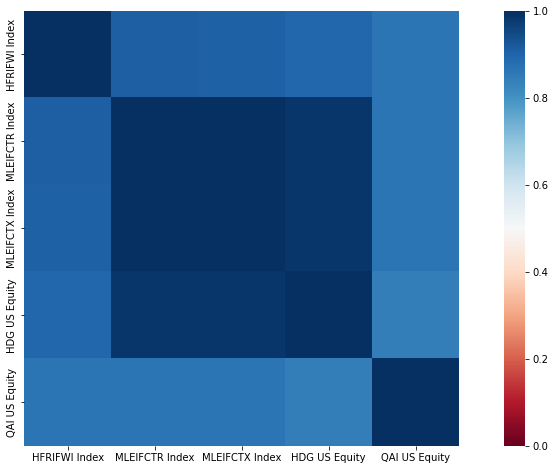

In [102]:
hm = sns.heatmap(corr, cbar = True, square = True, vmin = 0, cmap = 'RdBu')

hm = hm.set_yticklabels(labels = hm.get_yticklabels(), va = 'center')

This shows that the various hedge fund indices are very correlated.

### 5b.

### Minimum correlation

In [103]:
corr.unstack().idxmin()

('HDG US Equity', 'QAI US Equity')

### Maximum correlation

In [104]:
no_diag_corr = corr - np.identity(5)

no_diag_corr.unstack().idxmax()

('MLEIFCTR Index', 'MLEIFCTX Index')

## Question 6.

In [39]:
factor_data.columns

Index(['SPY US Equity', 'USGG3M Index', 'EEM US Equity', 'EFA US Equity',
       'EUO US Equity', 'IWM US Equity'],
      dtype='object')

In [41]:
#input data/independent
x = factor_data[['SPY US Equity', 'USGG3M Index', 'EEM US Equity', 'EFA US Equity',
       'EUO US Equity', 'IWM US Equity']]

# output/dependent data

y = data[['HFRIFWI Index']]

In [42]:
x.corr()

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
SPY US Equity,1.000000,-0.059214,0.728721,0.861743,-0.335292,0.881245
USGG3M Index,-0.059214,1.000000,-0.017261,-0.051726,0.034556,-0.084013
EEM US Equity,0.728721,-0.017261,1.000000,0.841453,-0.568168,0.694629
EFA US Equity,0.861743,-0.051726,0.841453,1.000000,-0.518697,0.790229
EUO US Equity,-0.335292,0.034556,-0.568168,-0.518697,1.000000,-0.265076
IWM US Equity,0.881245,-0.084013,0.694629,0.790229,-0.265076,1.000000


## Part A

In [67]:
# with statsmodels
X = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y,X).fit()
#predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:          HFRIFWI Index   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     113.7
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           5.84e-46
Time:                        11:12:54   Log-Likelihood:                 437.27
No. Observations:                 122   AIC:                            -860.5
Df Residuals:                     115   BIC:                            -840.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.387

/Users/peterfeng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [44]:
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 [0.0011467]
Coefficients: 
 [[ 0.07202237 -0.40059141  0.0721592   0.10631807  0.02243061  0.13089205]]


In [46]:
pd.DataFrame({'Coefficients':np.append(regr.coef_[0],regr.intercept_)},index=list(factor_data.columns)+['Intercept'])

,Coefficients
SPY US Equity,0.072022
USGG3M Index,-0.400591
EEM US Equity,0.072159
EFA US Equity,0.106318
EUO US Equity,0.022431
IWM US Equity,0.130892
Intercept,0.001147


## Part B

* Based on the regression that has been run, most of the betas are realisitic position sizes.


## Part C

In [47]:
from sklearn.metrics import r2_score

In [48]:
y_pred = regr.predict(x)

In [49]:
print(f"The r-squared as a percent is {r2_score(y, y_pred)*100}")

The r-squared as a percent is 85.56947723602491


## Part D

In [50]:
#The Tracking Error
round(model.resid.std() * np.sqrt(12),4)

0.0234

## Problem 7

In [124]:
#input data/independent
x_7 = data_merr[['SPY US Equity', 'USGG3M Index', 'EEM US Equity', 'EFA US Equity',
       'EUO US Equity', 'IWM US Equity']]
X_7 = sm.add_constant(data_merr[['SPY US Equity', 'USGG3M Index', 'EEM US Equity', 'EFA US Equity',
       'EUO US Equity', 'IWM US Equity']])

# output/dependent data

y_7 = data['HFRIFWI Index']

In [125]:
np.set_printoptions(suppress = True)

In [129]:
r2 = []

min_obv = 60

for i in range(min_obv, len(y_7)):

    err_x, err_null = [], []

    ### Data up to t
    currX = X_7.iloc[i-60:i]
    currY = y_7.iloc[i-60:i]

    ### Fit the model
    model_7 = sm.OLS(currY, currX, missing='drop').fit()

    pred = model_7.predict(X_7.iloc[[i]])[0]

    ### Forecast error of the regression
    err_x.append(y_7.iat[i] - pred)

    ### Null error is the actual value - the mean of previous values
    err_null.append(y_7.iat[i] - currY.mean())



    ### Calculate out-of-sample r2 using the errors we calculated
    r_sqr_oos = 1 - np.square(err_x).sum() / np.square(err_null).sum()
    
    r2.append(r_sqr_oos)
    
mean = np.array(r2).mean()
median = np.median(r2)

print("Mean:", mean, "Median:", median)

Mean: -2.4027028598877944 Median: 0.8279672094760194


In [65]:
rolling_model = RollingOLS(y,X,window=60)
rolling_betas = rolling_model.fit().params.copy()
rolling_betas

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
date,,,,,,,
2011-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-05-31,0.002788,0.075014,-1.534818,0.104951,0.097579,0.005371,0.147374
2021-06-30,0.002731,0.073925,-1.480456,0.105029,0.096860,0.003405,0.148293
2021-07-31,0.002791,0.068513,-1.495962,0.110204,0.094706,0.004556,0.151516


In [75]:
rep_IS = (rolling_betas * X).sum(axis=1,skipna=False)  ## in sample replication ## beta from t1 to t60 replicate value in t60
rep_OOS = (rolling_betas.shift() * X).sum(axis=1,skipna=False)  ## out of sample replication ## beta from t1 to t60 replicate value in t61
replication = data[['HFRIFWI Index']].copy()
replication['Static-IS-Int'] = model.fittedvalues 
replication['Rolling-IS-Int'] = rep_IS
replication['Rolling-OOS-Int'] = rep_OOS
replication

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int
date,,,,
2011-08-31,-0.032149,-0.030573,NaN,NaN
2011-09-30,-0.038903,-0.039685,NaN,NaN
2011-10-31,0.026858,0.049217,NaN,NaN
2011-11-30,-0.013453,-0.002153,NaN,NaN
2011-12-31,-0.004479,-0.001198,NaN,NaN
...,...,...,...,...
2021-05-31,0.013401,0.006256,0.008660,0.008153
2021-06-30,0.005424,0.005985,0.007253,0.007416
2021-07-31,-0.009095,-0.005717,-0.007452,-0.006910


In [76]:
replication.corr()

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int
HFRIFWI Index,1.000000,0.925038,0.966793,0.944550
Static-IS-Int,0.925038,1.000000,0.992091,0.994047
Rolling-IS-Int,0.966793,0.992091,1.000000,0.995595
Rolling-OOS-Int,0.944550,0.994047,0.995595,1.000000


<AxesSubplot:xlabel='date'>

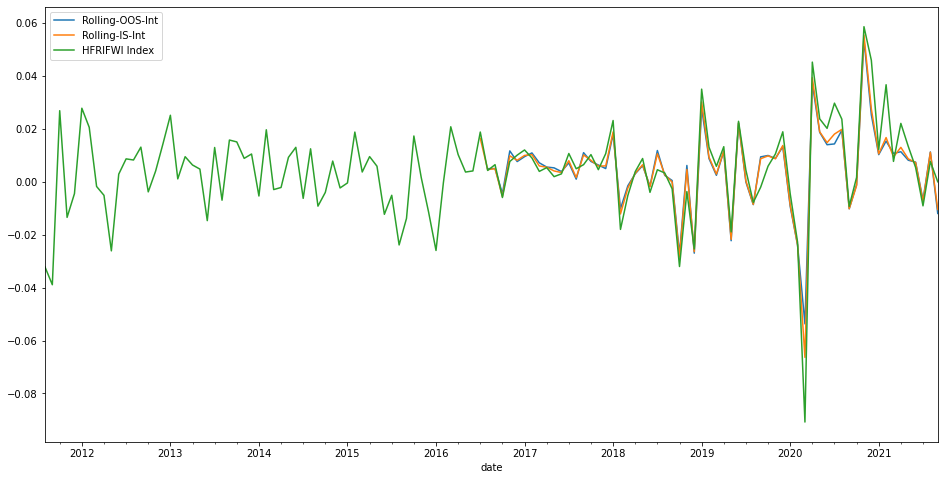

In [74]:
replication[['Rolling-OOS-Int','Rolling-IS-Int','HFRIFWI Index']].plot()

The out-of-sample replication performs very well with respect to the target. It has a very high correlation to the HFRI.

## Question 8.

### 8a.

In [77]:
r_hfri = data['HFRIFWI Index']

r_hfri

date
2011-08-31   -0.032149
2011-09-30   -0.038903
2011-10-31    0.026858
2011-11-30   -0.013453
2011-12-31   -0.004479
                ...   
2021-05-31    0.013401
2021-06-30    0.005424
2021-07-31   -0.009095
2021-08-31    0.007628
2021-09-30    0.000000
Name: HFRIFWI Index, Length: 122, dtype: float64

In [79]:
ols_no_int = sm.OLS(r_hfri, factor_data).fit()
print(ols_no_int.summary())

                                 OLS Regression Results                                
Dep. Variable:          HFRIFWI Index   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.854
Method:                 Least Squares   F-statistic:                              120.0
Date:                Mon, 12 Jun 2023   Prob (F-statistic):                    2.36e-47
Time:                        11:39:39   Log-Likelihood:                          436.25
No. Observations:                 122   AIC:                                     -860.5
Df Residuals:                     116   BIC:                                     -843.7
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [135]:
r_hfri_ann = r_hfri.mean() * 12

r_hfri_ann

0.050784216013560556

In [136]:
betas = ols_no_int.params

betas

SPY US Equity    0.087505
USGG3M Index     0.334503
EEM US Equity    0.069936
EFA US Equity    0.101524
EUO US Equity    0.023479
IWM US Equity    0.128999
dtype: float64

In [47]:
int_betas = model.params

int_betas

const            0.001147
SPY US Equity    0.072022
USGG3M Index    -0.400591
EEM US Equity    0.072159
EFA US Equity    0.106318
EUO US Equity    0.022431
IWM US Equity    0.130892
dtype: float64

It seems that by and large, they are quite similar except for the USGG3M Index, which swings from a large negative beta to a large positive beta. Most other parameters were relatively consistent with one another.

### 8b.

In [137]:
r_hfri_hat = (data_merr @ betas)

r_hfri_hat

date
2011-08-31   -0.031777
2011-09-30   -0.040618
2011-10-31    0.048568
2011-11-30   -0.003150
2011-12-31   -0.001905
                ...   
2021-05-31    0.004976
2021-06-30    0.005265
2021-07-31   -0.006288
2021-08-31    0.008250
2021-09-30   -0.012900
Length: 122, dtype: float64

In [80]:
print("The mean of the fitted value is", round(ols_no_int.fittedvalues.mean(),4)*12)

The mean of the fitted value is 0.0432


In [81]:
print("The mean of the HFRI is",round(data['HFRIFWI Index'].mean(),4)*12)

The mean of the HFRI is 0.0504


### 8c.

In [83]:
replication['Static-IS-NoInt'] = ols_no_int.fittedvalues
replication.corr()

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int,Static-IS-NoInt
HFRIFWI Index,1.000000,0.925038,0.966793,0.944550,0.924517
Static-IS-Int,0.925038,1.000000,0.992091,0.994047,0.999437
Rolling-IS-Int,0.966793,0.992091,1.000000,0.995595,0.990893
Rolling-OOS-Int,0.944550,0.994047,0.995595,1.000000,0.992507
Static-IS-NoInt,0.924517,0.999437,0.990893,0.992507,1.000000
